In this notebook we identify excitatory and inhibitory population parameters that allow a balanced, controllable propagation of activity along a "1D" ridge of hyperexcitable CA3 pyramidal neurons.

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import interpolate, optimize

import aux
from ntwk import LIFNtwk
from plot import raster, set_font_size
from traj import Traj, upstream_spks_from_traj

import PARAMETERS as P

cc = np.concatenate

SAVE_DIR = 'sims/balance'
HX_DIR = os.path.join(SAVE_DIR, 'hx')
W_N_PC_EC_PATH = os.path.join(HX_DIR, 'w_n_pc_ec.npy')
V_G_INIT_EC_PREFIX = os.path.join(HX_DIR, 'v_g_init_ec')

# HX PC Ridge

We first explore the properties of activity propagation along a ridge of hyperexcitable PCs, with no inhibition included.

### Determine expected EC->PC weight as a function of distance from ridge centerline

We do this by simulating the responses of a collection of PCs with place fields centered at different distances from the rat's current location. Afterwards, we measure the EC->PC weight as a function of these distances.

In [2]:
N = 200
DISTS = np.linspace(0, 0.2, N)
DUR = 5
STIM_ITVL = (0, 2)
N_TRIALS = 200

In [3]:
np.random.seed(0)

# build place fields
centers = np.array([DISTS, np.zeros(N)])
stds = P.L_PL * np.ones(N)
max_rates = P.R_MAX_PL * np.ones(N)

# get place-tuned inputs
ts = np.arange(0, DUR, P.DT)
xys = np.zeros((len(ts), 2))
traj = Traj(ts=ts, xys=xys)

# build ntwk
ws_up = {
    'AMPA': cc([P.W_A_PC_PL * np.eye(N), np.zeros((N, N))], axis=1),
    'NMDA': cc([np.zeros((N, N)), P.W_N_PC_EC_I * np.eye(N)], axis=1),
}
ws_rcr = {
    'AMPA': np.zeros((N, N)),
    'NMDA': np.zeros((N, N))
}
masks_plastic = {
    'AMPA': np.zeros(ws_up['AMPA'].shape, dtype=bool),
    'NMDA': cc([np.zeros((N, N)), np.eye(N)], axis=1).astype(bool),
}

ntwk = LIFNtwk(
    t_m=P.T_M_PC, e_l=P.E_L_PC, v_th=P.V_TH_PC, v_reset=P.V_RESET_PC, t_r=P.T_R,
    e_ahp=0, t_ahp=np.inf, w_ahp=0,
    es_syn={'AMPA': P.E_A, 'NMDA': P.E_N}, ts_syn={'AMPA': P.T_A, 'NMDA': P.T_N}, ws_up=ws_up, ws_rcr=ws_rcr,
    plasticity={
        'masks': masks_plastic,
        'w_ec_ca3_maxs': {'AMPA': np.nan, 'NMDA': P.W_N_PC_EC_F},
        'T_W': P.T_W, 'T_C': P.T_C, 'C_S': P.C_S, 'BETA_C': P.B_C,
    },
)

vs_init = np.repeat(P.E_L_PC, N)

ws_n_pc_ec = np.nan * np.zeros((N_TRIALS, N))

# run ntwk for n_trials
for ctr in range(N_TRIALS):
    if (ctr) % 10 == 0:
        print('Running simulations for trial {}/{} to {}/{}...'.format(
            ctr+1, N_TRIALS, min(ctr+10, N_TRIALS), N_TRIALS))
    spks_up_pl = upstream_spks_from_traj(ts, traj.xys, centers, stds, max_rates)

    # set all upstream spikes outside of stimulation interval to 0
    mask = ~( (ts >= STIM_ITVL[0]) & (ts < STIM_ITVL[1]) )
    spks_up_pl[mask] = 0

    spks_up = np.zeros((len(ts), 2*N))
    spks_up[:, :N] = spks_up_pl

    rsp = ntwk.run(spks_up, dt=P.DT, vs_init=vs_init)
    ws_n_pc_ec[ctr, :] = rsp.ws_plastic['NMDA'][-1]

Running simulations for trial 1/200 to 10/200...
Running simulations for trial 11/200 to 20/200...
Running simulations for trial 21/200 to 30/200...
Running simulations for trial 31/200 to 40/200...
Running simulations for trial 41/200 to 50/200...
Running simulations for trial 51/200 to 60/200...
Running simulations for trial 61/200 to 70/200...
Running simulations for trial 71/200 to 80/200...
Running simulations for trial 81/200 to 90/200...
Running simulations for trial 91/200 to 100/200...
Running simulations for trial 101/200 to 110/200...
Running simulations for trial 111/200 to 120/200...
Running simulations for trial 121/200 to 130/200...
Running simulations for trial 131/200 to 140/200...
Running simulations for trial 141/200 to 150/200...
Running simulations for trial 151/200 to 160/200...
Running simulations for trial 161/200 to 170/200...
Running simulations for trial 171/200 to 180/200...
Running simulations for trial 181/200 to 190/200...
Running simulations for trial 19

In [4]:
# save weight values so that new ones can be quickly sampled
aux.save(W_N_PC_EC_PATH, {'dists': DISTS, 'weights': ws_n_pc_ec})

'sims/balance/hx/w_n_pc_ec.npy'

### Create steady-state distribution of PC voltages and NMDA conductances in response to EC inputs as fn of EC->PC cxn weights

In [3]:
N = 200
EC_RATES = [40, 50, 60]
DUR = 21
START = 1
N_SAMPLES = 1000

ws_n_pc_ec = np.linspace(P.W_N_PC_EC_I, P.W_N_PC_EC_F, N)

# build PC ntwk with these EC->PC cxn weights
ws_up = {'NMDA': np.diag(ws_n_pc_ec)}
ws_rcr = {'NMDA': np.zeros((N, N))}

ntwk = LIFNtwk(
    t_m=P.T_M_PC, e_l=P.E_L_PC, v_th=P.V_TH_PC, v_reset=P.V_RESET_PC, t_r=P.T_R,
    e_ahp=0, t_ahp=np.inf, w_ahp=0,
    es_syn={'NMDA': P.E_N}, ts_syn={'NMDA': P.T_N},
    ws_up=ws_up, ws_rcr=ws_rcr)

# loop over EC rates
ts = np.arange(0, DUR, P.DT)
vs_init = P.E_L_PC * np.ones(N)

for ec_rate in EC_RATES:
    print('Running simulation for EC rate: {} Hz...'.format(ec_rate))
    
    # build upstream (EC) spk input
    spks_up = np.random.poisson(P.DT*ec_rate, (len(ts), N))
    
    # run ntwk
    rsp = ntwk.run(spks_up, P.DT, vs_init)
    
    # randomly sample vs and conductances
    vs_sample = np.nan * np.zeros((N_SAMPLES, N))
    gs_sample = np.nan * np.zeros((N_SAMPLES, N))
    
    for nrn_ctr in range(N):
        # pick random time points to sample vs and gs at
        tps_sample = np.random.choice(np.arange(int(START/P.DT), int(DUR/P.DT)), N_SAMPLES)
        vs_sample[:, nrn_ctr] = rsp.vs[tps_sample, nrn_ctr]
        gs_sample[:, nrn_ctr] = rsp.gs['NMDA'][tps_sample, nrn_ctr]
        
    # save results
    aux.save(
        '{}_{}Hz.npy'.format(V_G_INIT_EC_PREFIX, ec_rate),
        {'weights': ws_n_pc_ec, 'vs': vs_sample, 'gs': gs_sample})

Running simulation for EC rate: 40 Hz...
Running simulation for EC rate: 50 Hz...
Running simulation for EC rate: 60 Hz...


### Show distribution of weights, initial voltages, and initial NMDA conductances

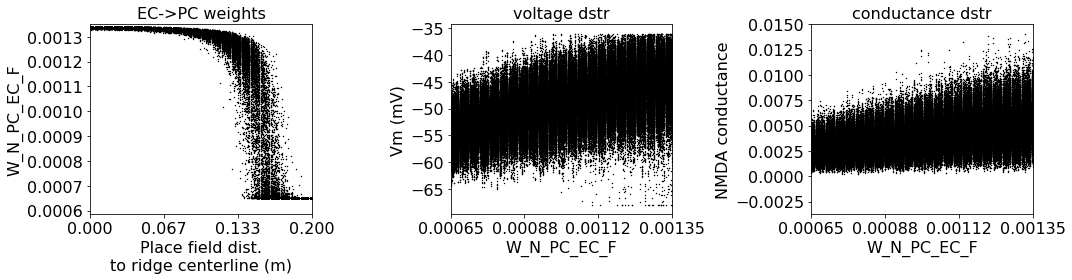

In [4]:
EC_RATE = 50

fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

# plot final weight vs. distance
temp = aux.load(W_N_PC_EC_PATH)
dists = temp['dists']
ws_n_pc_ec = temp['weights']

axs[0].scatter(np.tile(dists, (len(ws_n_pc_ec), 1)), ws_n_pc_ec, s=2, color='k', lw=0)
axs[0].set_xlim(dists[0], dists[-1])
axs[0].set_ylim(.9*P.W_N_PC_EC_I, P.W_N_PC_EC_F)
x_ticks = np.linspace(dists[0], dists[-1], 4)
x_tick_labels = ['{0:.3f}'.format(x_tick) for x_tick in x_ticks]

axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(x_tick_labels)
axs[0].set_xlabel('Place field dist.\nto ridge centerline (m)')
axs[0].set_ylabel('W_N_PC_EC_F')
axs[0].set_title('EC->PC weights')

# plot v and g distribution vs. EC->PC weight
temp = aux.load('{}_{}Hz.npy'.format(V_G_INIT_EC_PREFIX, EC_RATE))
ws_n_pc_ec = temp['weights']
vs = temp['vs']
gs = temp['gs']

for ctr, w in enumerate(ws_n_pc_ec):
    axs[1].scatter(w*np.ones(len(vs)), 1000* vs[:, ctr], s=2, c='k', lw=0)
    axs[2].scatter(w*np.ones(len(gs)), gs[:, ctr], s=2, c='k', lw=0)

x_ticks = np.linspace(P.W_N_PC_EC_I, P.W_N_PC_EC_F, 4)
x_tick_labels = ['{0:.5f}'.format(x_tick) for x_tick in x_ticks]

for ax in axs[1:]:
    ax.set_xlim(P.W_N_PC_EC_I, P.W_N_PC_EC_F)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlabel('W_N_PC_EC_F')

axs[1].set_ylabel('Vm (mV)')
axs[1].set_title('voltage dstr')
axs[2].set_ylabel('NMDA conductance')
axs[2].set_title('conductance dstr')

for ax in axs:
    set_font_size(ax, 16)

### Construct example ridge

We now build a "horizontal" ridge using the above parameters that becomes HX in response to EC inputs.

In [2]:
def ridge_h(shape, dens, hx):
    """
    Randomly sample PCs from along a "ridge", assigning them each a place-field
    center and an EC->PC cxn weight.
    
    :param shape: tuple specifying ridge shape (m)
    :param dens: number of place fields per m^2
    :param hx: dict with keys:
        'dists': array of uniformly spaced distances used to sample weights
        'weights': distribution of EC->PC NMDA cxn weights to sample from as fn of dists
    
    :return: place field centers, EC->PC cxn weights
    """
    # sample number of nrns
    n_pcs = np.random.poisson(shape[0] * shape[1] * dens)
    
    # sample place field positions
    centers = np.random.uniform((-shape[0]/2, -shape[1]/2), (shape[0]/2, shape[1]/2), (n_pcs, 2)).T
    
    # sample EC->PC cxn weights according to dists to centerline
    dd = np.mean(np.diff(hx['dists']))
    dist_idxs = np.round(np.abs(centers[1]) / dd).astype(int)
    
    ws = []
    for dist_idx in dist_idxs:
        w_dstr = hx['weights'][:, min(dist_idx, len(hx['dists'])-1)]
        ws.append(np.random.choice(w_dstr))
    
    return centers, ws

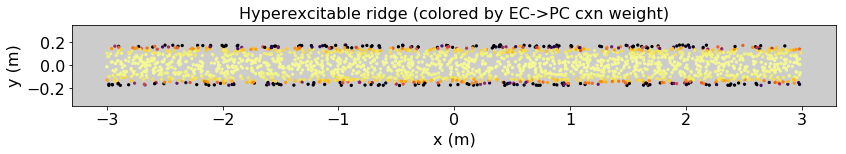

In [3]:
RIDGE_SHAPE = (6, 0.35)
PC_DENS = 1000

hx = aux.load(W_N_PC_EC_PATH)

centers, ws_n_pc_ec = ridge_h(RIDGE_SHAPE, PC_DENS, hx)

fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)
ax.set_facecolor((.8, .8, .8))
ax.scatter(centers[0], centers[1], s=5, c=ws_n_pc_ec, vmin=P.W_N_PC_EC_I, vmax=P.W_N_PC_EC_F, cmap='inferno')

ax.set_ylim(-RIDGE_SHAPE[1], RIDGE_SHAPE[1])
ax.set_aspect('equal')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Hyperexcitable ridge (colored by EC->PC cxn weight)')

set_font_size(ax, 16)

### Immediate ridge response to increasing PC activations

For different connectivity parameters we now simulate the response of the ridge to activating different numbers of initial PCs at the far left end of the ridge. Sufficiently strong responses ought to mean that if we let the simulation run longer we would see self-sustaining activity propagating along the ridge.

### Determine required place-tuned stimulation to elicit single spike

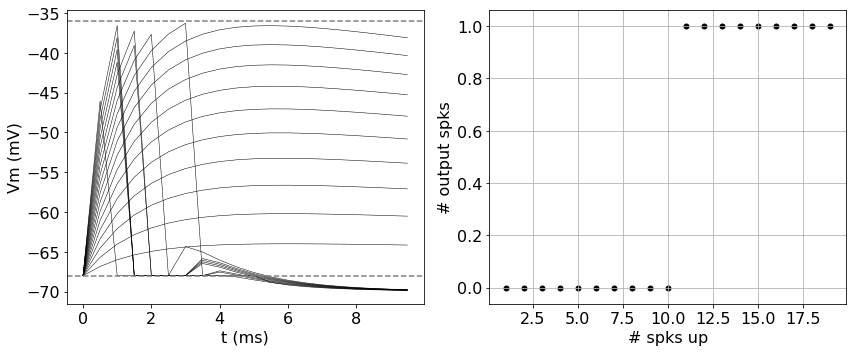

In [4]:
N_SPKS_UP = range(1, 20)

DUR = 0.01
E_AHP = -0.07
T_AHP = 0.05
W_AHP = .8

# make single-neuron ntwk
ntwk = LIFNtwk(
    t_m=P.T_M_PC, e_l=P.E_L_PC, v_th=P.V_TH_PC,
    v_reset=P.V_RESET_PC, t_r=P.T_R,
    e_ahp=E_AHP, t_ahp=T_AHP, w_ahp=W_AHP,
    es_syn={'AMPA': P.E_A},
    ts_syn={'AMPA': P.T_A},
    ws_up={'AMPA': P.W_A_PC_PL*np.eye(1)},
    ws_rcr={'AMPA': np.zeros((1, 1))})

ts = np.arange(0, DUR, P.DT)
vs_init = P.E_L_PC * np.ones(1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

n_spks_out = []

for n_spks_up in N_SPKS_UP:
    spks_up = np.zeros((len(ts), 1))
    spks_up[1] = n_spks_up
    
    # run ntwk
    rsp = ntwk.run(spks_up, P.DT, vs_init)
    
    # plot voltages
    axs[0].plot(1000 * ts, 1000*rsp.vs, color='k', lw=.5)
    
    # count spks
    n_spks_out.append(rsp.spks.sum())
    
axs[0].axhline(1000 * P.E_L_PC, color='gray', ls='--')
axs[0].axhline(1000 * P.V_TH_PC, color='gray', ls='--')

axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('Vm (mV)')

axs[1].scatter(N_SPKS_UP, n_spks_out, color='k', lw=0)
axs[1].grid()

axs[1].set_xlabel('# spks up')
axs[1].set_ylabel('# output spks')

for ax in axs:
    set_font_size(ax, 16)

### Run ntwk

In [5]:
def sample_vs_gs_init(ws_n_pc_ec, v_g_init):
    """
    Return an initial membrane voltage and NMDA conductance for each
    of several PCs, depending on their EC->PC cxn weight.
    """
    
    dw = np.mean(np.diff(v_g_init['weights']))
    w_idxs = np.round((ws_n_pc_ec - v_g_init['weights'][0])/ dw).astype(int)
    
    vs = np.nan * np.zeros(len(ws_n_pc_ec))
    gs = {'NMDA': np.nan * np.zeros(len(ws_n_pc_ec))}
    
    for nrn_ctr, w_idx in enumerate(w_idxs):
        vs[nrn_ctr] = np.random.choice(v_g_init['vs'][:, w_idx])
        gs['NMDA'][nrn_ctr] = np.random.choice(v_g_init['gs'][:, w_idx])
        
    return vs, gs

Running simulations for z_pc = 0.3, l_pc = 0.2:
Running trial 1/1...


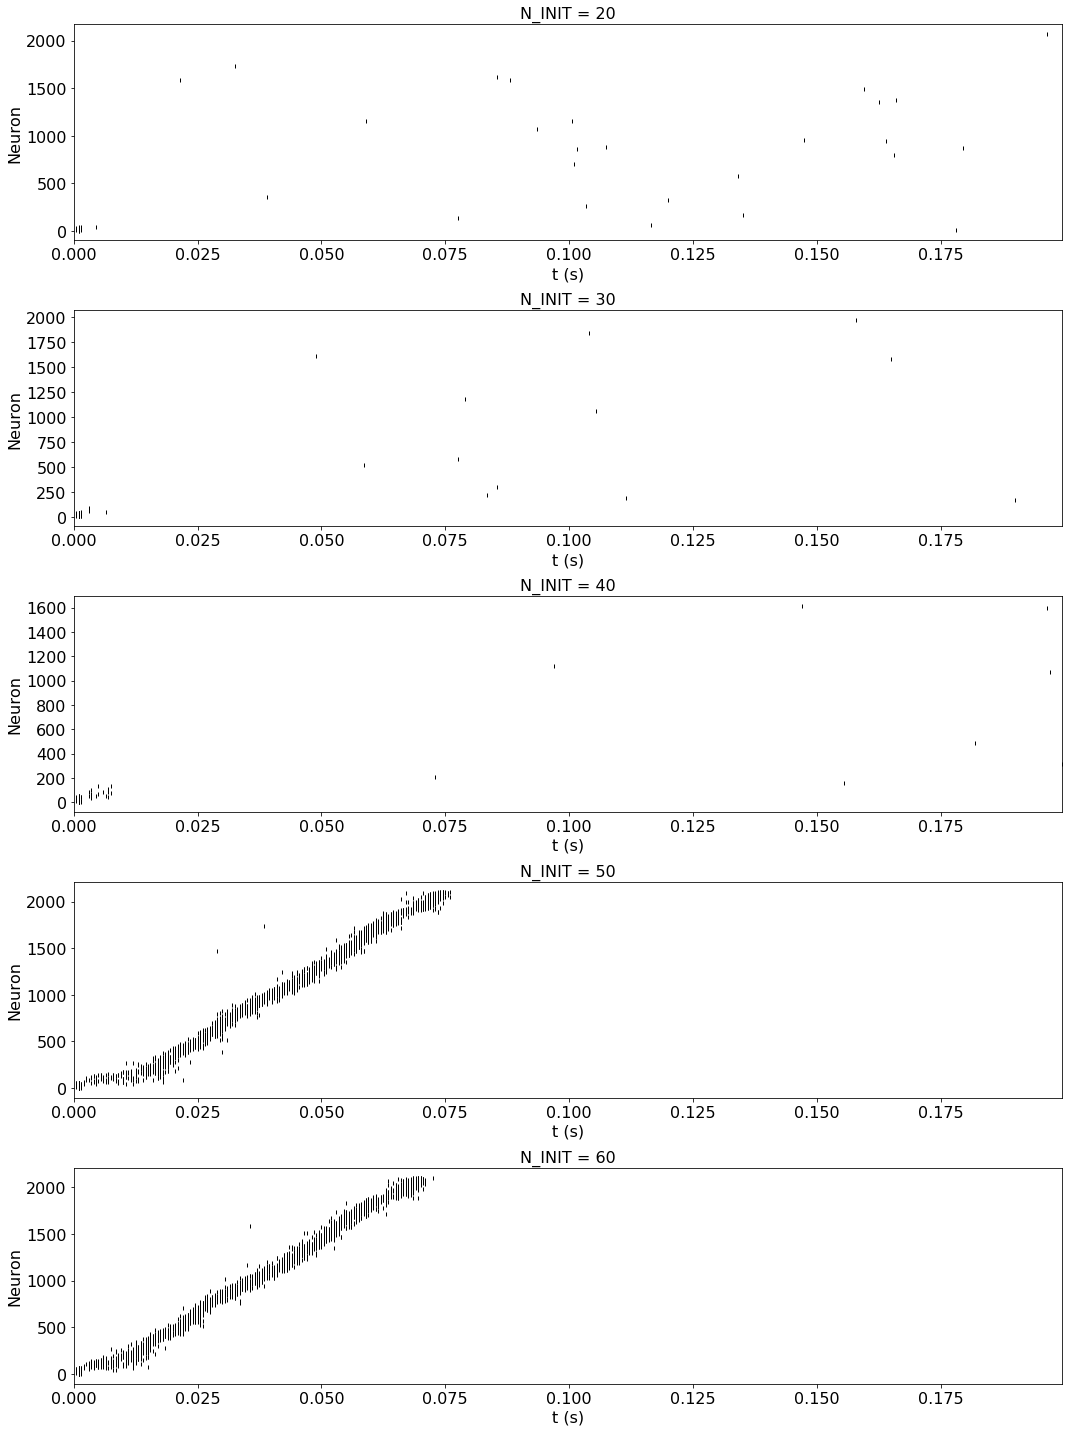

In [12]:
from itertools import product as cproduct
from ntwk import cxns_pcs_rcr

DUR = .2
NRNS_INIT = [20, 30, 40, 50, 60]
EC_RATE = 40

SINGLE_SPIKE_STIM = 11

Z_PCS = [.3]  #[.1, .2, .5, 1, 2, 5]
L_PCS = [.2]

N_TRIALS = 1

SHOW_RASTERS = True

np.random.seed(0)

hx = aux.load(W_N_PC_EC_PATH)
v_g_init = aux.load('{}_{}Hz.npy'.format(V_G_INIT_EC_PREFIX, EC_RATE))
ts = np.arange(0, DUR, P.DT)

for z_pc, l_pc in cproduct(Z_PCS, L_PCS):
    print('Running simulations for z_pc = {}, l_pc = {}:'.format(z_pc, l_pc))
    
    for tr_ctr in range(N_TRIALS):
        print('Running trial {}/{}...'.format(tr_ctr+1, N_TRIALS))
        
        # make ridge
        centers, ws_n_pc_ec = ridge_h(RIDGE_SHAPE, PC_DENS, hx)
        n = centers.shape[1]

        # sort nrns by distance to left-most point on ridge, which is
        # the order they'll be recruited into the initial stim
        dx = centers[0] + (RIDGE_SHAPE[0]/2)
        dy = centers[1]
        
        rcrt_order = np.argsort(np.sqrt(dx**2 + dy**2))
        
        # sort nrns by x-coordinate
        x_order = np.argsort(centers[0])
        
        # make upstream connectivity matrix
        ws_up_a = P.W_A_PC_PL * np.eye(n)
        ws_up_n = np.diag(ws_n_pc_ec)
        ws_up = {
            'AMPA': cc([ws_up_a, np.zeros((n, n))], axis=1),
            'NMDA': cc([np.zeros((n, n)), ws_up_n], axis=1),
        }

        # make recurrent connectivity matrix
        cxns = cxns_pcs_rcr(centers, z_pc, l_pc)
        ws_rcr = {'AMPA': P.W_A_PC_PC*cxns.astype(float), 'NMDA': np.zeros((n, n))}

        # make ntwk
        ntwk = LIFNtwk(
            t_m=P.T_M_PC, e_l=P.E_L_PC, v_th=P.V_TH_PC,
            v_reset=P.V_RESET_PC, t_r=P.T_R,
            e_ahp=E_AHP, t_ahp=T_AHP, w_ahp=W_AHP,
            es_syn={'AMPA': P.E_A, 'NMDA': P.E_N},
            ts_syn={'AMPA': P.T_A, 'NMDA': P.T_N},
            ws_up=ws_up, ws_rcr=ws_rcr)

        # sample initial voltages and NMDA conductances
        vs_init, gs_init = sample_vs_gs_init(ws_n_pc_ec, v_g_init)
        gs_init['AMPA'] = np.zeros(n)
        
        # loop over numbers of PCs to initially stimulate
        if SHOW_RASTERS:
            fig_size = (15, 4*len(NRNS_INIT))
            fig, axs = plt.subplots(len(NRNS_INIT), 1, figsize=fig_size, tight_layout=True, squeeze=False)
        
        for ax_ctr, n_init in enumerate(NRNS_INIT):
            
            # build initial upstream place-tuned input spk array
            spks_up = np.zeros((len(ts), 2*n))
            spks_up[1, rcrt_order[:n_init]] = SINGLE_SPIKE_STIM
            
            # add in EC inputs
            spks_up_ec = np.random.poisson(EC_RATE*P.DT, (len(ts), n))
            spks_up[:, n:] = spks_up_ec
            
            # run ntwk
            rsp = ntwk.run(spks_up, P.DT, vs_init=vs_init, gs_init=gs_init)
            
            if SHOW_RASTERS:
                ax = axs[ax_ctr, 0]
                raster(ax, ts, rsp.spks, order=x_order, lw=1)
                ax.set_title('N_INIT = {}'.format(n_init))
                set_font_size(ax, 16)

### PLOT

* (m x 2) ax fig, with each row corresponding to one set of Z/L params
* first col shows summed population activity over time, second col shows final pop activity vs. initial pop activity

### Activity propagation

We now ask, for ntwks where the ridge response was at least as great as the initial activation, whether activity propagates smoothly along the ridge when we let the simulation run for a full second.

### PLOT

* (m x 1) figure showing ntwk response rasters for selected set of Z_PC, L_PC pairs when triggered with sufficiently strong initial activations

# INH Pool

We now explore the potential that a pool of inhibitory neurons might have to bring the activity propagation into a precisely controllable regime.

### Dependence of INH response to PC inputs on distribution of PC-->INH cxn strengths

For several different distributions of PC-->INH cxn strengths, from a delta distribution where they're all the same, to a distribution heavily weighted on small cxn strengths, we measure the population response to specific numbers of input PC spikes over a subsequent small window of time.

### PLOT

* (m x 2) ax figure, with one row per set of INH distributions
* 1st col shows set of distributions of PC-->INH cxn strengths, with each distribution in a diff color
* 2nd col shows INH responses to diff numbers of triggering PC activations, each with error bars, color matched to first col

# Full HX Ridge Simulation

We now combine the excitation-only ridge simulation with an inhibitory population in our attempt to control the "operating" point of the network, that is, the average activation during propagation.

### PLOT

* (m x n) ax figure, one row per param set
* 1st col shows excitatory cxn probability curve and inhibitory distribution overlaid atop one another
* later cols show raster plots of activity for different trials